In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import keras.datasets as kds
import keras.backend as K

# Loading Fashion MNIST data

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

# Function for merging label and input:

In [ ]:
def edit_data(x, y, method="edit"):
    is_batch = x.ndim == 3
    if method == "edit":
        if is_batch:
            x[:, 0, :10] = 0.0
            for i in range(x.shape[0]):
                x[i, 0, y[i]] = 1.0
        else:
            x[0, :10] = 0.0
            x[0, y] = 1.0

# Function for creating a label for negative data:

In [ ]:
def random_label(y):
    if type(y) != np.ndarray:
        label = list(range(10))
        del label[y]
        return np.random.choice(label)
    else:
        label = np.copy(y)
        for i in range(y.shape[0]):
            label[i] = random_label(y[i])
        return label

# Constructing positive and negative data:

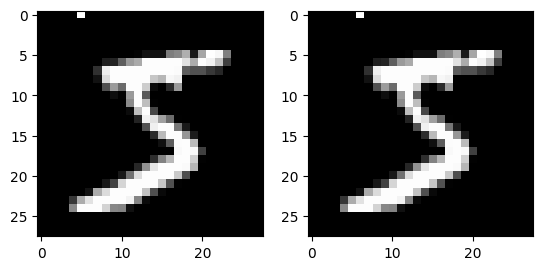

In [ ]:
pos = np.copy(x_train)
neg = np.copy(x_train)
edit_data(pos, y_train)
edit_data(neg, random_label(y_train))
_, ax = plt.subplots(1, 2)
ax[0].imshow(pos[0], cmap="gray")
ax[1].imshow(neg[0], cmap="gray")
plt.show()

# Loss function:
`y_true` can be 1 and -1. -1 for positive data and 1 for negative data. by this method we maximize goodness for positive data $-g+threshold$ and minimize goodness for negative data $g-thhreshold$

In [ ]:
def myLoss_with_threshold(threshold):
    def myLoss(y_true, y_pred):
        g = K.pow(y_pred, 2)
        g = K.mean(g, axis=1)
        g = g - threshold
        g = g * y_true
        loss = K.log(1 + K.exp(g))
        loss = K.mean(loss)
        return loss
    return myLoss

In [ ]:
pos = pos.reshape(pos.shape[0], -1)
neg = neg.reshape(neg.shape[0], -1)
pos.shape, neg.shape

((60000, 784), (60000, 784))

# Constructing Neural network:
In order to implement forward-forward correctly, we have to set an optimizer for each layer

In [ ]:
def normalize_(x_):
    return x_ / (tf.norm(x_, ord=2, axis=1, keepdims=True) + 1e-4)
layer1 = keras.Sequential([
    keras.layers.Dense(500, activation="relu", input_shape=[784])
])
layer2 = keras.Sequential([
    keras.layers.Dense(500, activation="relu", input_shape=[500])
])

In [ ]:
layer1.compile(loss=myLoss_with_threshold(2), optimizer=keras.optimizers.Adam())
layer2.compile(loss=myLoss_with_threshold(2), optimizer=keras.optimizers.Adam())

In [ ]:
from tqdm.auto import tqdm

# Training layer 1:

In [ ]:
batch_size = 1000
y_pos = np.ones((batch_size)) * -1
y_neg = np.ones((batch_size))
for ep in tqdm(range(30)):
  for b in range(pos.shape[0] // batch_size):
    x = pos[b * batch_size: (b + 1) * batch_size]
    layer1.fit(x, y_pos, batch_size=1000)
    x = neg[b * batch_size: (b + 1) * batch_size]
    layer1.fit(x, y_neg, batch_size=1000)

  0%|          | 0/30 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step - loss: 0.1924


In [ ]:
pos1 = layer1.predict(pos)
neg1 = layer1.predict(neg)
pos1 = normalize_(pos1)
neg1 = normalize_(neg1)
pos1.shape, neg1.shape

1875/1875 [==============================] - 3s 1ms/step


(TensorShape([60000, 500]), TensorShape([60000, 500]))

# Training layer 2:

In [ ]:
batch_size = 1000
for ep in tqdm(range(20)):
  for b in range(pos.shape[0] // batch_size):
    x = pos1[b * batch_size: (b + 1) * batch_size]
    layer2.fit(x, y_pos)
    x = neg1[b * batch_size: (b + 1) * batch_size]
    layer2.fit(x, y_neg)

  0%|          | 0/20 [00:00<?, ?it/s]

 1/32 [..............................] - ETA: 0s - loss: 0.4565

KeyboardInterrupt: ignored

# Test method for inference:

In [ ]:
def test(z):
  z = z.reshape(1, 784)
  zs = [np.copy(z) for _ in range(10)]
  for i in range(10):
    edit_data(zs[i], i)
  zs1 = [layer1.predict(zs[i], verbose=0) for i in range(10)]
  zsnorm = [normalize_(zs1[i]) for i in range(10)]
  zs2 = [layer2.predict(zsnorm[i], verbose=0) for i in range(10)]
  ans = np.array([np.mean(np.power(zs1[i], 2)) + np.mean(np.power(zs2[i], 2)) for i in range(10)])
  return np.argmax(ans)

0


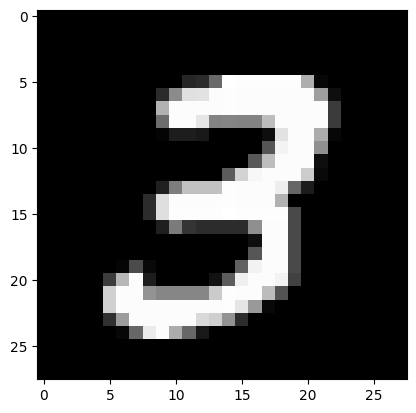

In [ ]:
z = x_train[7]
print(test(z))
plt.imshow(z, cmap="gray")

In [ ]:
acc = 0
test_acc = 0
for i in range(100):
  acc += test(x_train[i]) == y_train[i]
for i in range(100, 200):
  test_acc += test(x_test[i]) == y_test[i]
acc / 100, test_acc / 100

Exception ignored in: <function _xla_gc_callback at 0x7fd15bcbd940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: ignored

## My Version

In [ ]:
def FFLossWithThreshold(threshold):
    def FFLoss(y_true, y_pred, average=True):
        y_true, y_pred = tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32)
        g = K.pow(y_pred, 2)
        g = K.mean(g, axis=1)
        g = g - threshold
        g = g * y_true
        #g = g * y_true - g * (1. - y_true)
        loss = K.log(1 + K.exp(g))
        if average:
          loss = tf.reduce_mean(loss)
        return loss
    return FFLoss


class Norm(tf.keras.layers.Layer):
  def __init__(self, c=1e-4):
    super().__init__()
    self.c = c

  def call(self, x):
    x_norm = tf.norm(x, ord=2, axis=1, keepdims=True)
    return x / (x_norm + self.c)


def preproc(x, y, overlay=True, shuffle=True):
  x = tf.cast(x, tf.float32) / 255.
  if overlay:

    # randomly shuffle half of the batch
    if shuffle:
      # try hard splits for the batches
      if tf.math.less(tf.random.uniform([], dtype=tf.float32), 0.5): # 50/50 chance
        split = 0
      else:
        split = len(y)
      #split = len(y) // 2
      y = tf.concat([y[:split], tf.random.shuffle(y[split:])], axis=0)

    # replace the first 10 vals in x with the encoding for y
    one_hot_y = tf.cast(tf.one_hot(y, depth=10), tf.float32)  # shape: (batch_size, num_classes)
    #one_hot_y = tf.reshape(one_hot_y, [-1, 10, 1, 1])  # shape: (batch_size, 1, 1, num_classes)
    one_hot_y = tf.concat([one_hot_y[:, :, None, None], x[:, 10:, :1, :]], axis=1)
    x = tf.concat([one_hot_y, x[:, :, 1:, :]], axis=2)

    # set real/false labels for y
    if shuffle:
      y = tf.concat([tf.ones_like(y[:split]) * -1, tf.ones_like(y[split:])], axis=0)

  return x, y

In [ ]:
layer1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    #Norm(),
    tf.keras.layers.Dense(500, activation="relu")
    ])

layer2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    #Norm(),
    tf.keras.layers.Dense(500, activation="relu")
    ])

layer1.compile(loss=FFLossWithThreshold(2), optimizer=keras.optimizers.Adam())
layer2.compile(loss=FFLossWithThreshold(2), optimizer=keras.optimizers.Adam())

(28, 28, 1) ()


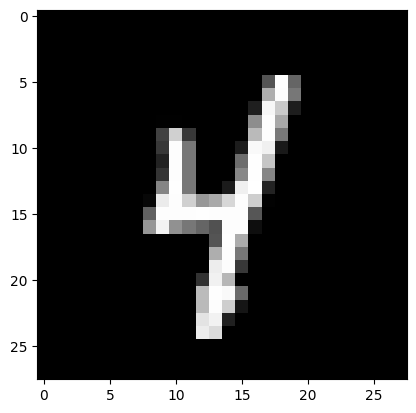

In [ ]:
import tensorflow_datasets as tfds

train_dataset = tfds.load("mnist", split='train[:90%]', as_supervised=True)
val_dataset = tfds.load("mnist", split='train[90%:]', as_supervised=True)
for x, y in train_dataset.take(1):
  plt.imshow(x, cmap="gray")
  print(x.shape, y.shape)

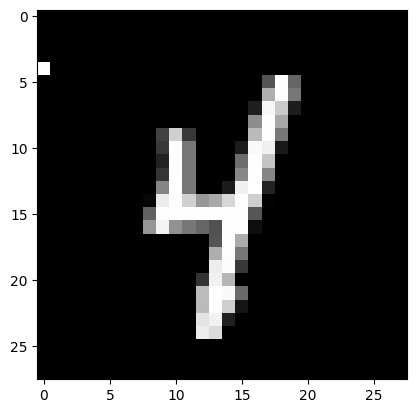

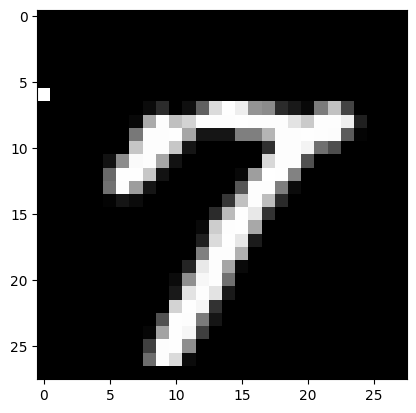

In [ ]:
for x, y in train_dataset.batch(32).map(preproc).take(1):
  plt.imshow(x[0], cmap="gray")
  plt.show()
  plt.imshow(x[16], cmap="gray")

In [ ]:
layer1.fit(train_dataset.shuffle(100000).batch(128).map(preproc), epochs=50)
layer2.fit(train_dataset.shuffle(100000).batch(128).map(preproc).map(lambda x,y:(layer1(x),y)), epochs=50)


Epoch 1/50
422/422 [==============================] - 6s 5ms/step - loss: 0.8081
Epoch 2/50
422/422 [==============================] - 2s 3ms/step - loss: 0.7823
Epoch 3/50
422/422 [==============================] - 2s 3ms/step - loss: 0.7379
Epoch 4/50
422/422 [==============================] - 2s 3ms/step - loss: 0.6884
Epoch 5/50
422/422 [==============================] - 2s 3ms/step - loss: 0.6500
Epoch 6/50
422/422 [==============================] - 2s 3ms/step - loss: 0.6118
Epoch 7/50
422/422 [==============================] - 2s 4ms/step - loss: 0.5832
Epoch 8/50
422/422 [==============================] - 2s 3ms/step - loss: 0.5540
Epoch 9/50
422/422 [==============================] - 2s 3ms/step - loss: 0.5358
Epoch 10/50
422/422 [==============================] - 2s 3ms/step - loss: 0.5127
Epoch 11/50
422/422 [==============================] - 2s 3ms/step - loss: 0.5010
Epoch 12/50
422/422 [==============================] - 2s 3ms/step - loss: 0.4789
Epoch 13/50
422/422 [====

In [ ]:
avg_acts = []
for candidate in range(10):
  for x, test_y in val_dataset.batch(100000).take(1):
    y = tf.ones_like(test_y) * candidate
    x, y = preproc(x, y, shuffle=False)
    x1 = layer1(x)
    x2= layer2(x1)
    #avg_act = layer1.loss(y, x1, average=False) + layer2.loss(y, x2, average=False)
    avg_act = tf.reduce_mean(tf.math.pow(x1, 2), axis=1) + tf.reduce_mean(tf.math.pow(x2, 2), axis=1)
  avg_acts.append(avg_act)

avg_acts = tf.transpose(tf.convert_to_tensor(avg_acts))
pred = tf.math.argmax(avg_acts, axis=-1)

tf.reduce_sum(tf.cast(tf.math.equal(pred, test_y), tf.int32)) / len(test_y)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9641666666666666>

In [ ]:
readout = tf.keras.Sequential([tf.keras.layers.Dense(10, activation="softmax")])
readout.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(), metrics="accuracy")


readout.fit(train_dataset.shuffle(100000).batch(1024).map(lambda x,y:(layer2(layer1(x)),y)),
            validation_data=val_dataset.batch(100000).map(lambda x,y:(layer2(layer1(x)),y)),
            epochs=20)

Epoch 1/20
53/53 [==============================] - 2s 30ms/step - loss: 84.1861 - accuracy: 0.5753 - val_loss: 15.9902 - val_accuracy: 0.8113
Epoch 2/20
53/53 [==============================] - 2s 37ms/step - loss: 11.2130 - accuracy: 0.8395 - val_loss: 10.8766 - val_accuracy: 0.8495
Epoch 3/20
53/53 [==============================] - 2s 27ms/step - loss: 7.9064 - accuracy: 0.8675 - val_loss: 8.7914 - val_accuracy: 0.8638
Epoch 4/20
53/53 [==============================] - 2s 27ms/step - loss: 6.2894 - accuracy: 0.8800 - val_loss: 7.4553 - val_accuracy: 0.8745
Epoch 5/20
53/53 [==============================] - 2s 31ms/step - loss: 5.1876 - accuracy: 0.8879 - val_loss: 6.4843 - val_accuracy: 0.8833
Epoch 6/20
53/53 [==============================] - 2s 27ms/step - loss: 4.3941 - accuracy: 0.8948 - val_loss: 5.8182 - val_accuracy: 0.8865
Epoch 7/20
53/53 [==============================] - 3s 41ms/step - loss: 3.7859 - accuracy: 0.8989 - val_loss: 5.3062 - val_accuracy: 0.8905
Epoch 8/2

In [ ]:
# compare against a direct readout (without the FF layers)
readout = tf.keras.Sequential([tf.keras.layers.Dense(10, activation="softmax")])
readout.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(), metrics="accuracy")


readout.fit(train_dataset.shuffle(100000).batch(1024).map(lambda x,y:(tf.reshape(x, [-1, 28*28]),y)),
            validation_data=val_dataset.batch(100000).map(lambda x,y:(tf.reshape(x, [-1, 28*28]),y)),
            epochs=20)

Epoch 1/20
53/53 [==============================] - 54s 8ms/step - loss: 47.4832 - accuracy: 0.5353 - val_loss: 13.5540 - val_accuracy: 0.7847
Epoch 2/20
53/53 [==============================] - 1s 5ms/step - loss: 10.8706 - accuracy: 0.8146 - val_loss: 8.9692 - val_accuracy: 0.8370
Epoch 3/20
53/53 [==============================] - 1s 5ms/step - loss: 8.0111 - accuracy: 0.8472 - val_loss: 7.2947 - val_accuracy: 0.8518
Epoch 4/20
53/53 [==============================] - 0s 4ms/step - loss: 6.5551 - accuracy: 0.8610 - val_loss: 6.3285 - val_accuracy: 0.8645
Epoch 5/20
53/53 [==============================] - 1s 5ms/step - loss: 5.6288 - accuracy: 0.8718 - val_loss: 5.5874 - val_accuracy: 0.8700
Epoch 6/20
53/53 [==============================] - 1s 5ms/step - loss: 4.9475 - accuracy: 0.8783 - val_loss: 5.0571 - val_accuracy: 0.8772
Epoch 7/20
53/53 [==============================] - 0s 5ms/step - loss: 4.3689 - accuracy: 0.8822 - val_loss: 4.6346 - val_accuracy: 0.8803
Epoch 8/20
53/53